In [1]:
import bioframe as bf
import gpn.model
from gpn.utils import load_table, Genome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from umap import UMAP
import umap
import umap.plot

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default

In [2]:
MODEL = "gonzalobenegas/gpn-brassicales"
#MODEL = "kmers_5"

d = Path("output/embedding")
#d = Path("output/embedding/subset_no_repeats")

windows = pd.read_parquet(d / "windows.parquet")
windows.loc[:, ["UMAP1", "UMAP2"]] = pd.read_parquet(d / "umap" / f"{MODEL}.parquet").values
windows

,chrom,start,end,strand,center_start,center_end,Region,UMAP1,UMAP2
0,1,0,512,+,206,306,intergenic,-0.028450,6.717154
1,1,100,612,+,306,406,intergenic,-0.238723,6.999189
2,1,200,712,+,406,506,intergenic,-0.622261,6.540700
3,1,300,812,+,506,606,intergenic,-0.317216,7.171642
4,1,400,912,+,606,706,intergenic,-0.569555,6.597675
...,...,...,...,...,...,...,...,...,...
818088,5,26974534,26975046,+,26974740,26974840,intergenic,0.268297,6.255438
818089,5,26974634,26975146,+,26974840,26974940,intergenic,-1.554088,2.486017
818090,5,26974734,26975246,+,26974940,26975040,intergenic,-0.515367,2.835551
818091,5,26974834,26975346,+,26975040,26975140,intergenic,-0.267551,3.624983


In [3]:
windows.Region = windows.Region.replace({
    "intergenic": "Intergenic",
    "intron": "Intron",
    "ncRNA_gene": "ncRNA",
    "five_prime_UTR": "5' UTR",
    "three_prime_UTR": "3' UTR",
})

In [4]:
mapper = UMAP()
mapper.embedding_ = windows[["UMAP1", "UMAP2"]].values

In [5]:
def get_color_key(classes, palette):
    color_palette = sns.color_palette(palette, n_colors=len(classes)).as_hex()
    return {c: color_palette[i] for i, c in enumerate(classes)}

def umap_plot_labels(labels, title, label_order, cmap="tab10", save_to=None, **kwargs):
    g = umap.plot.points(
        mapper,
        labels=labels,
        subset_points=labels.isin(label_order),
        color_key=get_color_key(label_order, cmap),
        **kwargs,
    );
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
    g.legend_.set_title(title);
    sns.despine();
    for txt in g.texts:
        txt.set_visible(False)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")

In [6]:
plt.rcParams["figure.dpi"] = 200  # need to play with both this and height,width

In [7]:
# avoid having both green and red
color_palette = np.array(sns.color_palette("tab10"))[[0,1,9,3,4,5,6]]

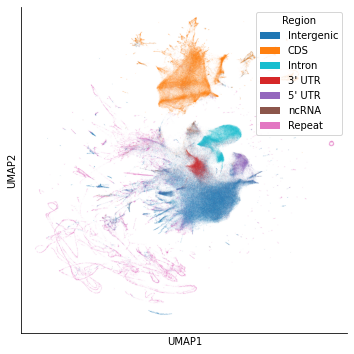

In [8]:
regions = windows.Region.value_counts().index.values

# Make sure Repeat goes last
if "Repeat" in regions:
    regions = regions[regions!="Repeat"].tolist() + ["Repeat"]

    
umap_plot_labels(
    windows.Region, "Region", regions, cmap=color_palette,
    height=1200, width=1200, 
    #height=900, width=900, 
    save_to=f"output/plots/umap_{MODEL.replace('/', '_')}.svg",
)

In [9]:
windows.Region.value_counts()

Region
Intergenic    299778
CDS           197787
Repeat        155170
Intron         79844
3' UTR         46154
5' UTR         30061
ncRNA           9299
Name: count, dtype: int64

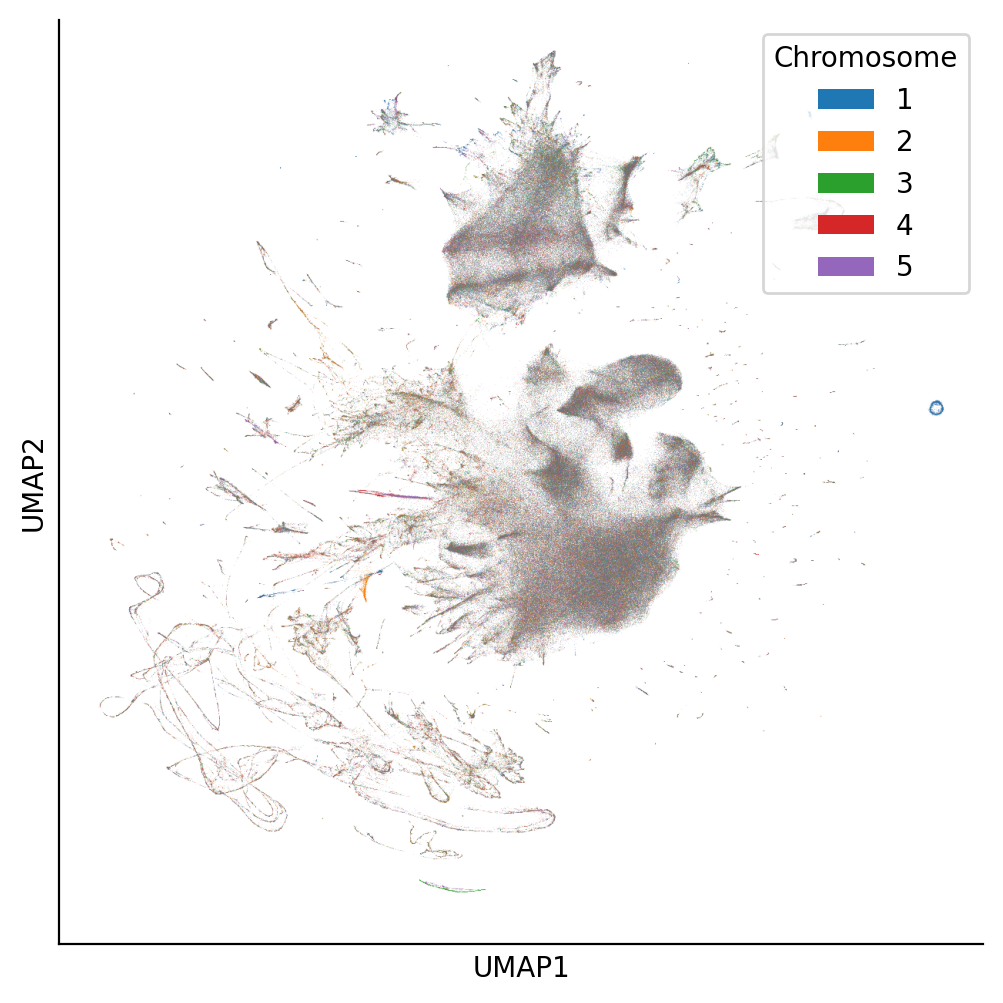

In [48]:
umap_plot_labels(windows.chrom, "Chromosome", windows.chrom.unique(), height=1200, width=1200)

In [49]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,10,444,191,54,76,1,12582773,12582920,-17844751,-,Helitron1,RC,Helitron,-9953,5856,5713,5
1,10,6899,30,0,1,1,13630758,13631561,-16796110,-,ATENSPM2,DNA,CMC-EnSpm,-6268,1985,1184,6
2,10,2521,72,3,2,1,14676131,14685672,-15741999,-,AR3,Satellite,Satellite,-73,9553,1,6
3,10,6227,45,48,6,1,15728234,15729041,-14698630,+,ATCopia95LTR,LTR,Copia,1,841,0,8
4,11,537,291,44,131,1,18873944,18874466,-11553205,-,Atlantys3_LTR,LTR,Gypsy,-12,482,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69340,587,238,156,0,0,M,361356,361401,-5523,-,SSU-rRNA_Ath,rRNA,rRNA,-16,1886,1842,6
69341,587,278,263,0,0,M,361523,361599,-5325,-,SSU-rRNA_Ath,rRNA,rRNA,-164,1738,1663,6
69342,587,582,289,31,44,M,362179,362407,-4517,-,SSU-rRNA_Ath,rRNA,rRNA,-481,1421,1197,6
69343,587,336,258,62,42,M,364854,365016,-1908,+,LSU-rRNA_Ath,rRNA,rRNA,797,961,-2414,6


In [50]:
top_repClass = repeats.repClass.value_counts().head(7).index.values
print(top_repClass)
repeats.repClass.value_counts()

['Simple_repeat' 'Low_complexity' 'DNA' 'LTR' 'RC' 'LINE' 'Satellite']


Simple_repeat     35153
Low_complexity     8892
DNA                8585
LTR                8576
RC                 3882
LINE               1785
Satellite          1347
SINE                616
Other               165
DNA?                112
RC?                  93
LINE?                74
rRNA                 48
SINE?                17
Name: repClass, dtype: int64

In [51]:
repeats.repFamily.value_counts()

Simple_repeat     35153
Low_complexity     8892
Gypsy              5580
MULE-MuDR          3942
Helitron           3882
Copia              2271
L1                 1785
DNA                1281
CMC-EnSpm           853
hAT-Ac              765
centr               752
Cassandra           725
Satellite           595
TcMar-Pogo          468
PIF-Harbinger       420
hAT                 386
TcMar-Stowaway      337
tRNA                334
SINE                282
Composite           161
DNA?                112
hAT-Tag1             99
Helitron?            93
LINE?                74
rRNA                 48
TcMar-Mariner        34
SINE?                17
centromeric           4
Name: repFamily, dtype: int64

In [52]:
repeats.repName.value_counts()

A-rich       5966
(T)n         2878
GA-rich      2864
(A)n         2192
(AT)n        2166
             ... 
(TGCTTG)n       1
(AAAGTG)n       1
(CTCCAA)n       1
(AGCTAG)n       1
(TGACT)n        1
Name: repName, Length: 4194, dtype: int64

In [53]:
# if a window overlaps multiple repeats we just take the first one
windows = bf.overlap(windows, repeats, how="left").drop_duplicates(["chrom", "center_start"])
windows

,chrom,start,end,strand,center_start,center_end,Region,UMAP1,UMAP2,#bin_,...,end_,genoLeft_,strand_,repName_,repClass_,repFamily_,repStart_,repEnd_,repLeft_,id_
0,1,0,512,+,206.0,306.0,Intergenic,-0.028450,6.717154,585.0,...,107,-30427564.0,-,ATREP18,DNA,DNA,-1142.0,649.0,561.0,1.0
1,1,100,612,+,306.0,406.0,Intergenic,-0.238723,6.999189,585.0,...,107,-30427564.0,-,ATREP18,DNA,DNA,-1142.0,649.0,561.0,1.0
2,1,200,712,+,406.0,506.0,Intergenic,-0.622261,6.540700,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
3,1,300,812,+,506.0,606.0,Intergenic,-0.317216,7.171642,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
4,1,400,912,+,606.0,706.0,Intergenic,-0.569555,6.597675,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897457,5,26974534,26975046,+,26974740.0,26974840.0,Intergenic,0.268297,6.255438,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897458,5,26974634,26975146,+,26974840.0,26974940.0,Intergenic,-1.554088,2.486017,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897459,5,26974734,26975246,+,26974940.0,26975040.0,Intergenic,-0.515367,2.835551,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN
897460,5,26974834,26975346,+,26975040.0,26975140.0,Intergenic,-0.267551,3.624983,NaN,...,<NA>,NaN,None,None,None,None,NaN,NaN,NaN,NaN


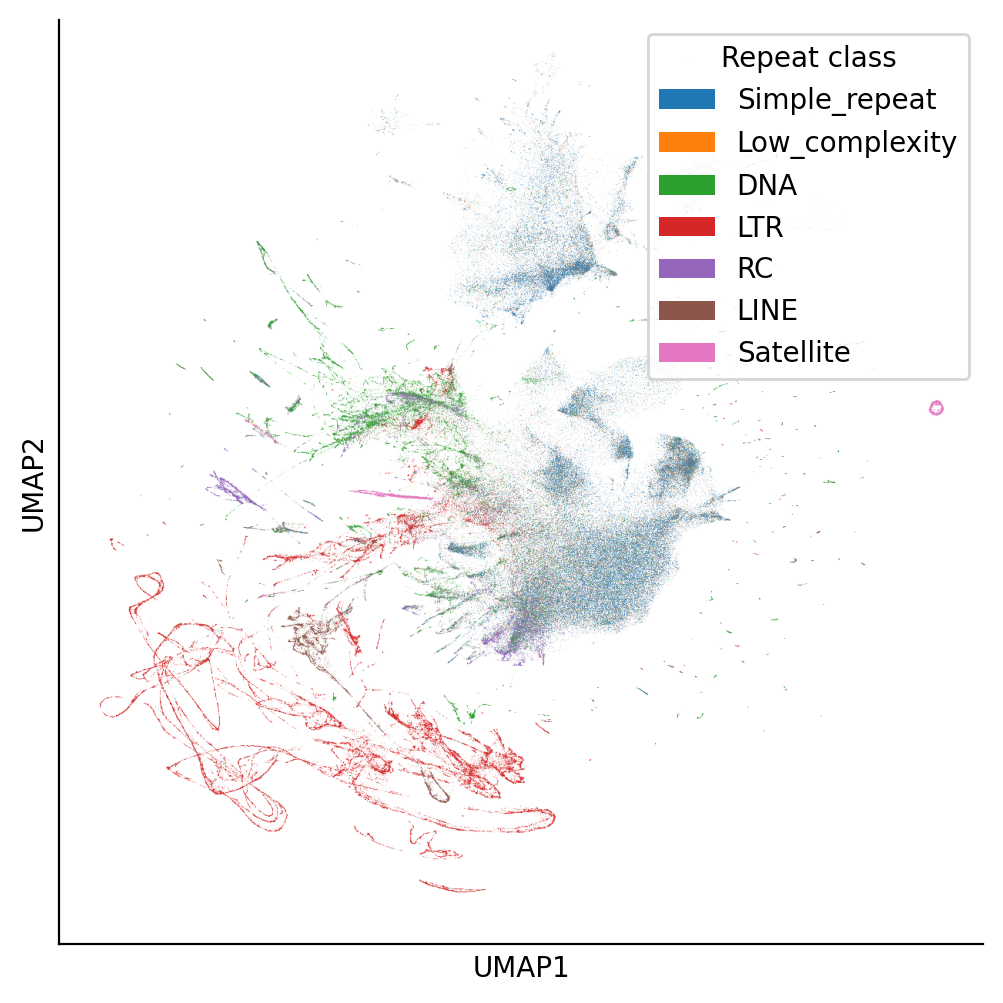

In [54]:
umap_plot_labels(windows.repClass_, "Repeat class", top_repClass, height=1200, width=1200)

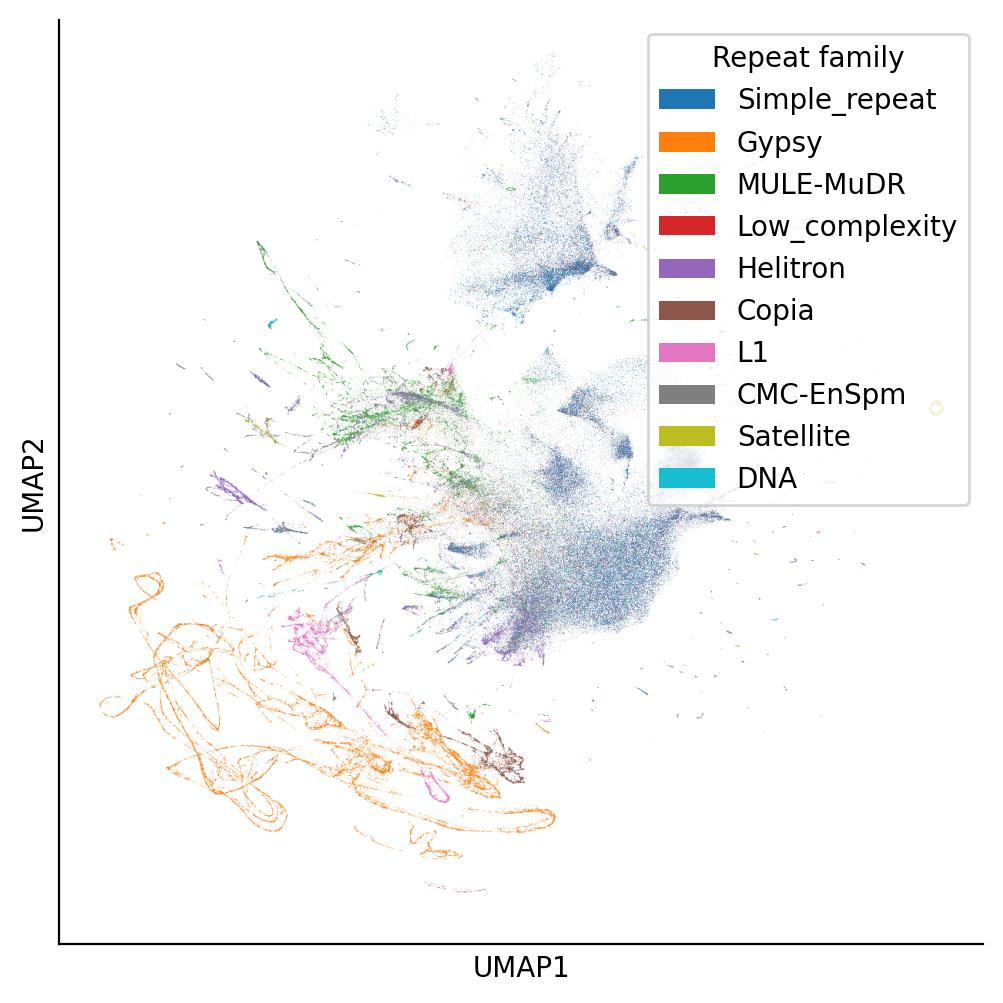

In [55]:
# maybe use a different color palette
umap_plot_labels(windows.repFamily_, "Repeat family", windows.repFamily_.value_counts().head(10).index.values, height=1200, width=1200, save_to="output/plots/umap_repeat_family.pdf")

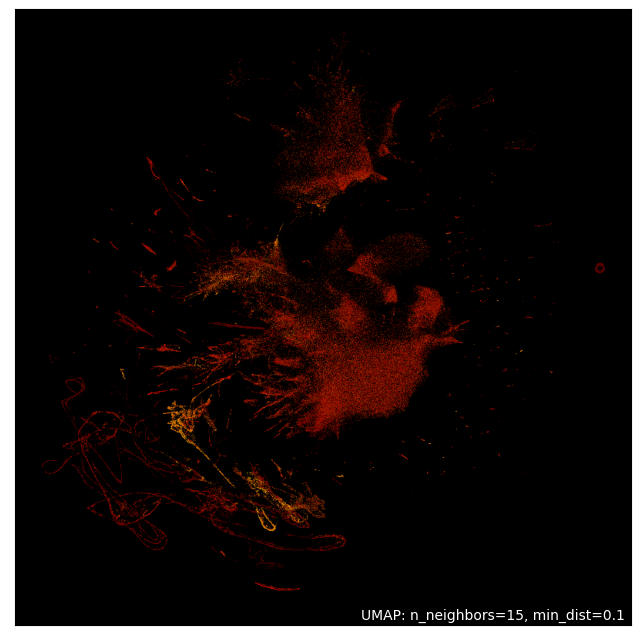

In [16]:
# no idea how to plot colorbar yet
# could just do it in seaborn extracting mapper.embedding
# or with datashader
labels = windows.milliDiv_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

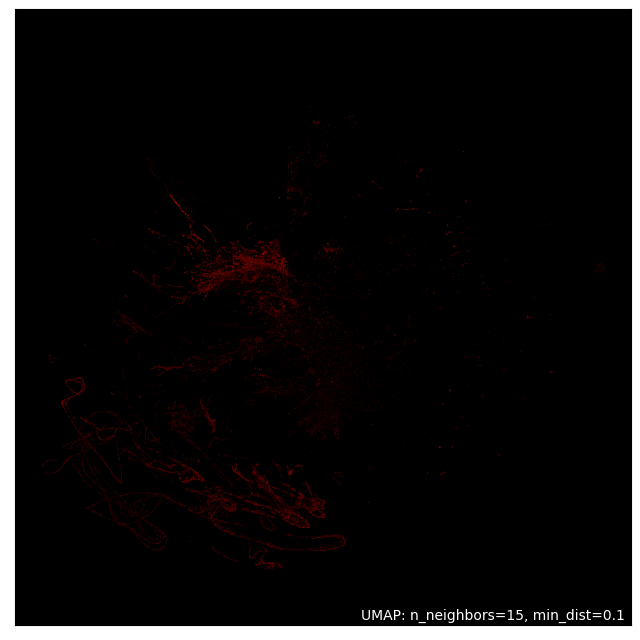

In [17]:
labels = windows.swScore_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

In [18]:
# https://github.com/lmcinnes/umap/issues/485

def umap_plot_values(values, title, cmap="viridis"):
    subset_points = ~values.isna()
    from matplotlib import colors, cm
    fig, ax = plt.subplots(figsize=(8,8))
    # create a scalar colour map for values
    norm = colors.Normalize(values.min(), values.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
    # plot using umaps helper function
    umap.plot.points(mapper, values=values, ax=ax, cmap=cmap, subset_points=subset_points)
    # create a colorbar
    cbar = fig.colorbar(scalar_map, ax=ax, label=title, shrink=0.25)  # type: ignore

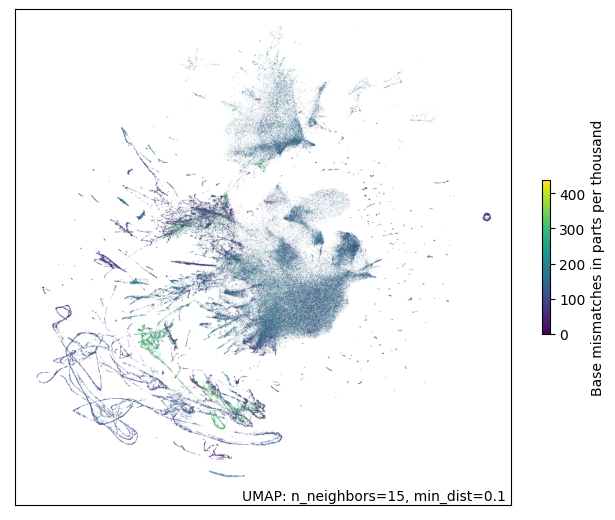

In [19]:
umap_plot_values(windows.milliDiv_, "Base mismatches in parts per thousand")

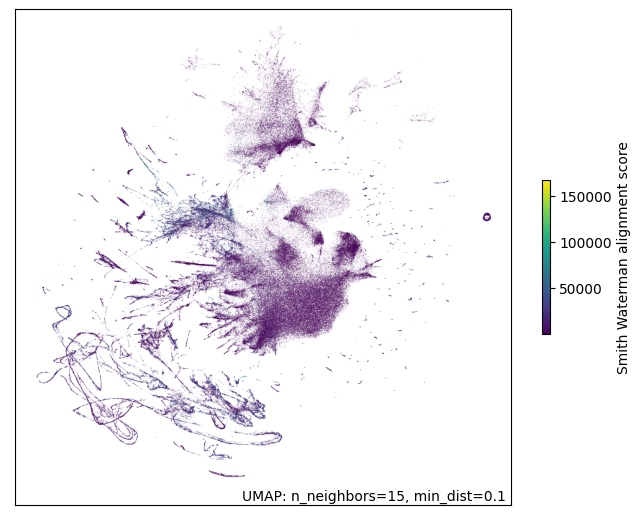

In [20]:
umap_plot_values(windows.swScore_, "Smith Waterman alignment score")